In [2]:
!pip install kaggle #install kaggle


StatementMeta(, , -1, Cancelled, , Cancelled)

In [ ]:
#connect to the api
import os
from kaggle.api.kaggle_api_extended import KaggleApi
os.environ['KAGGLE_USERNAME'] = 'omarrrelgoharyy'
os.environ['KAGGLE_KEY'] = '01b3eadb1f02f4350986e30cde9cca3b'

api = KaggleApi()
api.authenticate()

api.dataset_download_file('jockeroika/properties-for-rent-online', 'listings 2 reduced.csv')

StatementMeta(, , -1, Cancelled, , Cancelled)

In [11]:
# Load data into pandas DataFrame from "/lakehouse/default/Files/listings%202%20reduced.csv"
import pandas as pd
df = pd.read_csv("/lakehouse/default/Files/listings%202%20reduced.csv")
display(df)


StatementMeta(, 3e050328-80a1-4a01-a60a-3c57e2153236, 13, Finished, Available, Finished)

/tmp/ipykernel_6090/2534763268.py:3: DtypeWarning: Columns (68) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("/lakehouse/default/Files/listings%202%20reduced.csv")


SynapseWidget(Synapse.DataFrame, 3b3dac31-7e5e-4d68-a087-0a9e59b7db51)

In [ ]:
#normalization using pandas

host_cols=['host_id','host_url','host_name','host_since','host_location','host_about','host_response_time','host_response_rate','host_acceptance_rate','host_is_superhost','host_thumbnail_url','host_picture_url','host_neighbourhood','host_listings_count','host_total_listings_count','host_verifications','host_has_profile_pic','host_identity_verified']
df_hosts = df[host_cols].drop_duplicates(subset=['host_id'])

df_hosts.to_parquet("/lakehouse/default/Tables/host", engine="pyarrow", index=False)
print(df_hosts)

StatementMeta(, , -1, Cancelled, , Cancelled)

In [12]:
#normalization using pandas
listing_cols=['id','listing_url','scrape_id','last_scraped','source','description','host_id','price','neighbourhood','review_scores_rating','review_scores_accuracy','review_scores_cleanliness','review_scores_checkin','review_scores_communication','review_scores_location','review_scores_value','latitude','longitude']
df_listings = df[listing_cols].drop_duplicates(subset=['id'])

df_listings.to_parquet("/lakehouse/default/Tables/Listings", engine="pyarrow", index=False)
print(df_listings)

StatementMeta(, 3e050328-80a1-4a01-a60a-3c57e2153236, 14, Finished, Available, Finished)

                       id                                      listing_url  \
0                   92644               https://www.airbnb.com/rooms/92644   
1                   93015               https://www.airbnb.com/rooms/93015   
2                   13913               https://www.airbnb.com/rooms/13913   
3                   15400               https://www.airbnb.com/rooms/15400   
4                   93734               https://www.airbnb.com/rooms/93734   
...                   ...                                              ...   
87941  973781286754517228  https://www.airbnb.com/rooms/973781286754517228   
87942  973801695874775338  https://www.airbnb.com/rooms/973801695874775338   
87943  973811685656289740  https://www.airbnb.com/rooms/973811685656289740   
87944  973882998775927897  https://www.airbnb.com/rooms/973882998775927897   
87945  973895808066047620  https://www.airbnb.com/rooms/973895808066047620   

            scrape_id last_scraped       source  \
0      20230

In [ ]:
#change datatype to date and save by spark
from pyspark.sql import SparkSession
from pyspark.sql.functions import to_date

spark = SparkSession.builder.getOrCreate()
df_host_spark = spark.createDataFrame(df_hosts)

df_hosts = df_hosts.withColumn(
    "host_since",
    to_date("host_since", "yyyy-MM-dd")
)


df_hosts.write \
    .format("delta") \
    .mode("overwrite") \
    .option("overwriteSchema", "true") \
    .saveAsTable("hosts")
    


StatementMeta(, , -1, Cancelled, , Cancelled)

In [14]:
#change the datatype from string to date
from pyspark.sql import SparkSession
from pyspark.sql.functions import to_date


spark = SparkSession.builder.getOrCreate()
df_listings_spark = spark.createDataFrame(df_listings)
df_listings_spark = df_listings_spark.withColumn(
    "last_scraped",
    to_date("last_scraped", "yyyy-MM-dd")
)


df_listings_spark.write \
    .format("delta") \
    .mode("overwrite") \
    .option("overwriteSchema", "true") \
    .saveAsTable("cleaned_listings")


StatementMeta(, 3e050328-80a1-4a01-a60a-3c57e2153236, 16, Finished, Available, Finished)

In [21]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col

df_listings_spark=df_listings_spark.withColumn("price",col("price").cast("int"))

df_listings_spark.write \
   .format("delta") \
   .mode("overwrite") \
   .option("overwriteSchema","true") \
   .saveAsTable("cleaned_listings")

StatementMeta(, fdea16fd-3fc3-41db-8657-d251ede43f78, 24, Finished, Available, Finished)

In [16]:
#create cleaned table (transform the data)
from pyspark.sql import SparkSession
from pyspark.sql.functions import regexp_replace,col


sqark = SparkSession.builder.getOrCreate()
df_listings_spark=spark.createDataFrame(df_listings)
df_listings_spark.createOrReplaceTempView("listings")


result = spark.sql("""
CREATE TABLE cleaned_listings AS
SELECT
    id,
    listing_url,
    scrape_id,
last_scraped,
source,

description,
host_id,
CAST(regexp_replace(price, '[$,]', '') AS DOUBLE) AS price_cleaned,
neighbourhood,
review_scores_rating,
review_scores_accuracy,
review_scores_cleanliness,
review_scores_checkin,
review_scores_communication,
review_scores_location,
review_scores_value,
latitude,
longitude
FROM listings;

 """)


   
result.show()

StatementMeta(, 3e050328-80a1-4a01-a60a-3c57e2153236, 18, Finished, Available, Finished)

++
||
++
++



In [35]:
#transform data by removing $ to be easy to measure the avg price

df = spark.table("cleaned_listings") \
    .withColumn("price_cleaned", regexp_replace("price", "[$,]", "").cast("double"))

df.write \
    .format("delta") \
    .mode("overwrite") \
    .option("overwriteSchema", "true") \
    .saveAsTable("cleaned_listings")

StatementMeta(, fdea16fd-3fc3-41db-8657-d251ede43f78, 38, Finished, Available, Finished)

In [6]:
#calculate avg price with spark sql
result=spark.sql("""
select avg(price_cleaned) from cleaned_listings --first task
""")

result.show()

StatementMeta(, 3e050328-80a1-4a01-a60a-3c57e2153236, 8, Finished, Available, Finished)

+------------------+
|avg(price_cleaned)|
+------------------+
|181.34981693311806|
+------------------+



In [5]:
result = spark.sql(""" --second task
select distinct neighbourhood,count(id) as numbers_in_neighbourhood from cleaned_listings
group by neighbourhood
order by numbers_in_neighbourhood desc
""" )
result.show()

StatementMeta(, 3e050328-80a1-4a01-a60a-3c57e2153236, 7, Finished, Available, Finished)

+--------------------+------------------------+
|       neighbourhood|numbers_in_neighbourhood|
+--------------------+------------------------+
|                NULL|                   40755|
|Greater London, E...|                   33337|
|London, United Ki...|                    5448|
|London, England, ...|                    4833|
|London, Greater L...|                     663|
|Greater London, U...|                     208|
|Wembley Park, Eng...|                     119|
|London , England,...|                     113|
|England, United K...|                      74|
|Twickenham, Unite...|                      38|
|London, UK, Unite...|                      32|
|Richmond, England...|                      31|
|Kingston upon Tha...|                      29|
|Harlington, Engla...|                      29|
|Greater London, E...|                      27|
|Croydon, England,...|                      26|
|Richmond, United ...|                      26|
|Woodford, England...|                  

In [17]:
result = spark.sql("""
select id,review_scores_rating as highest_score from cleaned_listings
order by highest_score desc
"""
)
result.show()

StatementMeta(, 3e050328-80a1-4a01-a60a-3c57e2153236, 19, Finished, Available, Finished)

+------------------+-------------+
|                id|highest_score|
+------------------+-------------+
|819989557352514357|          5.0|
|859921595422762713|          5.0|
|          44286000|          5.0|
|          18752915|          5.0|
|          26711894|          5.0|
|          27575887|          5.0|
|          27576393|          5.0|
|          27600924|          5.0|
|          29820901|          5.0|
|          31508044|          5.0|
|          40663749|          5.0|
|          40885352|          5.0|
|          41131601|          5.0|
|           1287226|          5.0|
|           2575674|          5.0|
|           5498948|          5.0|
|           7171027|          5.0|
|           7550784|          5.0|
|879483206966511465|          5.0|
|653634262224229224|          5.0|
+------------------+-------------+
only showing top 20 rows



In [4]:

result=spark.sql(
    """
    select hosts.host_name,max(cleaned_listings.price_cleaned) as highest_price from hosts inner join cleaned_listings 
    on hosts.host_id=cleaned_listings.host_id
    group by hosts.host_name
    order by highest_price DESC
    """
)

result.show()

StatementMeta(, 3e050328-80a1-4a01-a60a-3c57e2153236, 6, Finished, Available, Finished)

+---------------+-------------+
|      host_name|highest_price|
+---------------+-------------+
|          Rajia|      80100.0|
|         Yvonne|      53588.0|
|         Daniel|      36000.0|
|          Osnat|      25000.0|
|             Mo|      25000.0|
|          David|      20362.0|
|Smart Solutions|      20000.0|
|           Eloi|      12000.0|
|UnderTheDoormat|      10028.0|
|     Travelnest|      10000.0|
|        Patrick|      10000.0|
|       Alkhalil|      10000.0|
|       Karolina|      10000.0|
|        Azimali|       9999.0|
|       Jermaine|       9999.0|
|         Ruslan|       9999.0|
|        Dainius|       9999.0|
|          Andre|       9999.0|
|      Alexandra|       9857.0|
|          Veeve|       9547.0|
+---------------+-------------+
only showing top 20 rows



StatementMeta(, 115175cb-b06e-4acd-a499-69176760b928, 44, Finished, Available, Finished)

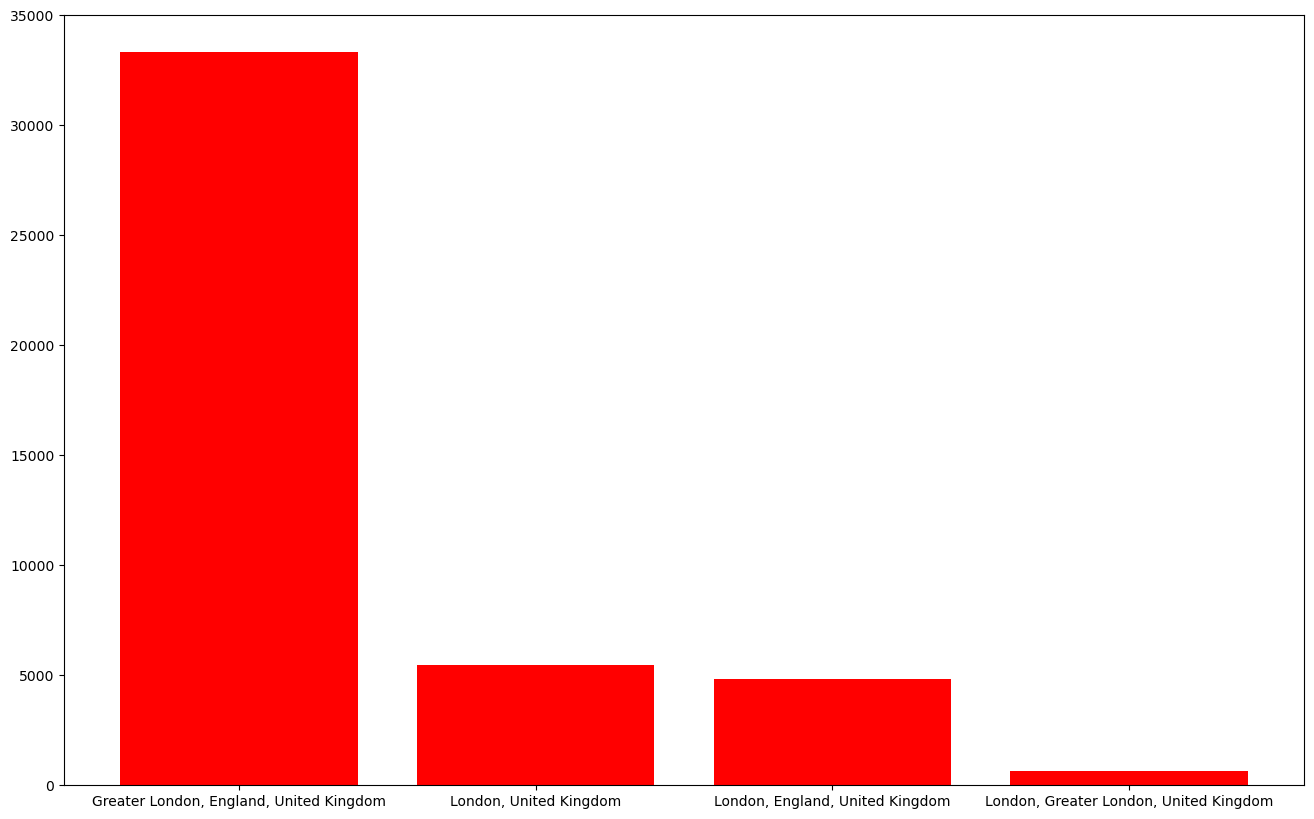

In [37]:
#visualize the top 4
top4_neighborhoods = spark.sql("""
    SELECT neighbourhood, COUNT(id) AS id_count
    FROM cleaned_listings
    WHERE neighbourhood IS NOT NULL
    GROUP BY neighbourhood
    ORDER BY id_count DESC
    LIMIT 4
""")

top4_pd = top4_neighborhoods.toPandas()

import matplotlib.pyplot as plt
plt.figure(figsize=(16,10))
plt.bar(top4_pd["neighbourhood"],top4_pd["id_count"],color="red")
plt.xlabel=("neighbourhood")
plt.ylabel=("id")
plt.show()

StatementMeta(, e32b6bde-56d5-4862-80eb-175d8a063e89, 35, Finished, Available, Finished)

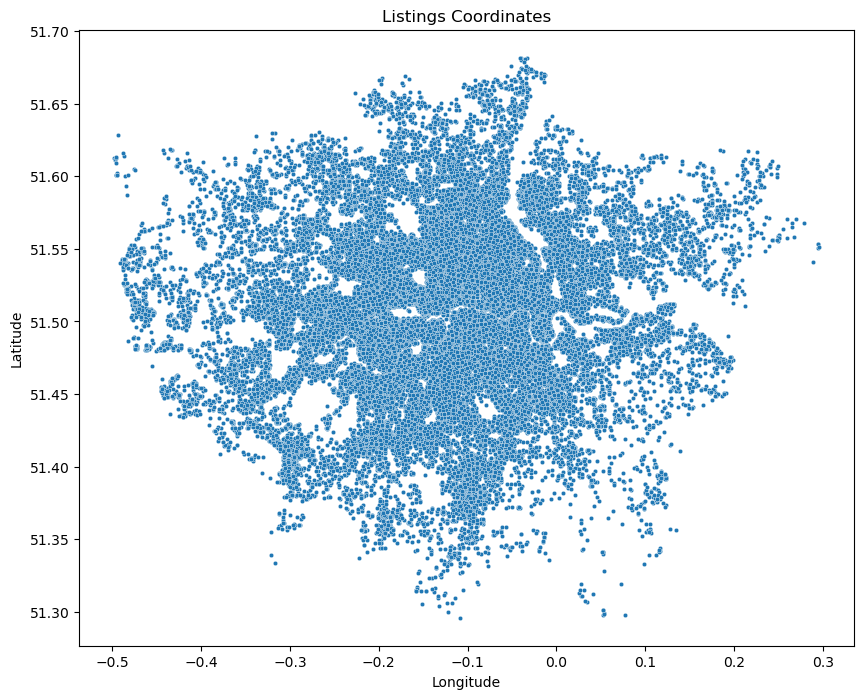

In [28]:
import seaborn as sns
import matplotlib.pyplot as plt

# Get data from Spark
map_graph = spark.sql("""
    SELECT id, latitude, longitude 
    FROM cleaned_listings
    WHERE latitude IS NOT NULL AND longitude IS NOT NULL
""")

map_graph_pd = map_graph.toPandas()

# Create scatter plot
plt.figure(figsize=(10, 8))
sns.scatterplot(
    data=map_graph_pd,
    x="longitude",
    y="latitude",
    hue=None,  # You can set hue="id" or another column if needed
    s=10
)

plt.title("Listings Coordinates")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.show()




In [14]:
#full code
 
#load data into lakehouse
import pandas as pd
df = pd.read_csv("/lakehouse/default/Files/listings%202%20reduced.csv")


#normalizaation table with pandas
host_cols=['host_id','host_url','host_name','host_since','host_location','host_about','host_response_time','host_response_rate','host_acceptance_rate','host_is_superhost','host_thumbnail_url','host_picture_url','host_neighbourhood','host_listings_count','host_total_listings_count','host_verifications','host_has_profile_pic','host_identity_verified']
df_hosts = df[host_cols].drop_duplicates(subset=['host_id'])
df_hosts.to_parquet("/lakehouse/default/Tables/host", engine="pyarrow", index=False)


listing_cols=['id','listing_url','scrape_id','last_scraped','source','description','host_id','price','neighbourhood','review_scores_rating','review_scores_accuracy','review_scores_cleanliness','review_scores_checkin','review_scores_communication','review_scores_location','review_scores_value','latitude','longitude']
df_listings = df[listing_cols].drop_duplicates(subset=['id'])

df_listings.to_parquet("/lakehouse/default/Tables/Listings", engine="pyarrow", index=False)


#transform by changing column data type from string to date
from pyspark.sql import SparkSession
from pyspark.sql.functions import to_date
spark = SparkSession.builder.getOrCreate()
df_listings_spark = spark.createDataFrame(df_listings)
df_listings_spark = df_listings_spark.withColumn(
    "last_scraped",
    to_date("last_scraped", "yyyy-MM-dd")
)
df_listings_spark.write \
    .format("delta") \
    .mode("overwrite") \
    .option("overwriteSchema", "true") \
    .saveAsTable("listings")

#change column from string to int
from pyspark.sql import SparkSession
from pyspark.sql.functions import col
df_listings_spark=df_listings_spark.withColumn("price",col("price").cast("int"))
df_listings_spark.write \
   .format("delta") \
   .mode("overwrite") \
   .option("overwriteSchema","true") \
  .saveAsTable("listings")

#transform into cleaned table by removing the char from the column
from pyspark.sql import SparkSession
from pyspark.sql.functions import regexp_replace,col

sqark = SparkSession.builder.getOrCreate()
df_listings_spark=spark.createDataFrame(df_listings)
df_listings_spark.createOrReplaceTempView("listings")

result = spark.sql("""
CREATE TABLE cleaned_listings AS
SELECT
    id,
    listing_url,
    scrape_id,
last_scraped,
source,

 CAST(regexp_replace(price, '[$,]', '') AS DOUBLE) AS price_cleaned,
description,
host_id,
price,
neighbourhood,
review_scores_rating,
review_scores_accuracy,
review_scores_cleanliness,
review_scores_checkin,
review_scores_communication,
review_scores_location,
review_scores_value,
latitude,
longitude
FROM listings;

 """)
#save the cleaned table 
df_listings_spark.write \
   .format("delta") \
   .mode("overwrite") \
   .option("overwriteSchema","true") \
   .saveAsTable("cleaned_listings")

result=spark.sql(
    """
    select host_since from hosts

    """
)
result.show()



StatementMeta(, fdea16fd-3fc3-41db-8657-d251ede43f78, 16, Finished, Available, Finished)

/tmp/ipykernel_9184/2593320238.py:3: DtypeWarning: Columns (68) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("/lakehouse/default/Files/listings%202%20reduced.csv")


+----------+
|host_since|
+----------+
|2017-03-16|
|2014-08-23|
|2015-05-03|
|2018-06-11|
|2017-08-03|
|2018-11-12|
|2019-03-30|
|2011-03-13|
|2019-06-16|
|2017-08-16|
|2016-03-02|
|2019-08-07|
|2015-07-09|
|2019-10-08|
|2019-04-17|
|2013-01-29|
|2016-10-21|
|2018-03-22|
|2015-02-04|
|2012-01-11|
+----------+
only showing top 20 rows

